In [2]:
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
base_url = "https://data.epa.gov/efservice/downloads/tri/mv_tri_basic_download/"
suffix_url = "_US/csv"

output_dir = 'tri_data_2014_2023'
os.makedirs(output_dir, exist_ok=True)

for year in range(2014, 2024):
    download_url = f"{base_url}{year}{suffix_url}"
    file_name = f"tri_data_{year}.csv"
    file_path = os.path.join(output_dir, file_name)
    response = requests.get(download_url)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download data for {year}, status code: {response.status_code}")

input_dir = 'tri_data_2014_2023'
dataframes = []
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path, low_memory=False)
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)
combined_csv_path = 'combined_tri_data_2014_2023.csv'
combined_df.to_csv(combined_csv_path, index=False)
print(f"Combined CSV saved to {combined_csv_path}")



Downloaded tri_data_2014.csv
Downloaded tri_data_2015.csv
Downloaded tri_data_2016.csv
Downloaded tri_data_2017.csv
Downloaded tri_data_2018.csv
Downloaded tri_data_2019.csv
Downloaded tri_data_2020.csv
Downloaded tri_data_2021.csv
Downloaded tri_data_2022.csv
Downloaded tri_data_2023.csv
Combined CSV saved to combined_tri_data_2014_2023.csv


In [4]:
data=pd.read_csv('combined_tri_data_2014_2023.csv',low_memory=False)
data.shape

(806162, 122)

In [5]:
print("Total number of rows and columns before exploration: ",data.shape)
data.head()

Total number of rows and columns before exploration:  (806162, 122)


,1. YEAR,2. TRIFD,3. FRS ID,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,8. ST,9. ZIP,10. BIA,...,113. 8.2 - ENERGY RECOVER ON,114. 8.3 - ENERGY RECOVER OF,115. 8.4 - RECYCLING ON SITE,116. 8.5 - RECYCLING OFF SIT,117. 8.6 - TREATMENT ON SITE,118. 8.7 - TREATMENT OFF SITE,119. PRODUCTION WSTE (8.1-8.7),120. 8.8 - ONE-TIME RELEASE,121. PROD_RATIO_OR_ ACTIVITY,122. 8.9 - PRODUCTION RATIO
0,2017,75243DRSNF13532,1.100021e+11,DRS NIS LLC,13532 N CENTRAL EXPRESSWAY,DALLAS,DALLAS,TX,75243,NaN,...,0.0,9498.00,0.0,0.0,0.0,12615.0,33549.0,NaN,PRODUCTION,1.40
1,2017,26041KMMRPRTE2X,1.100137e+11,AMERICAN ELECTRIC POWER KAMMER/MITCHELL PLANT,RT # 2,MOUNDSVILLE,MARSHALL,WV,26041,NaN,...,0.0,0.00,0.0,0.0,0.0,0.0,17202.0,NaN,PRODUCTION,0.95
2,2017,39168GRGPCHIGHW,1.100006e+11,GEORGIA-PACIFIC LLC,13136 HWY 28 WEST,TAYLORSVILLE,SMITH,MS,39168,NaN,...,0.0,0.00,2900.0,0.0,300000.0,940.0,327845.0,NaN,PRODUCTION,0.51
3,2017,40403TKCSN301MA,1.100007e+11,HITACHI ASTEMO AMERICAS INC. - BEREA KY,301 MAYDE RD,BEREA,MADISON,KY,40403,NaN,...,0.0,7192.35,0.0,0.0,0.0,0.0,31866.8,NaN,PRODUCTION,0.90
4,2017,32087WRMLNONEWI,1.100004e+11,INSTEEL WIRE PRODUCTS,ONE WIRE MILL RD,SANDERSON,BAKER,FL,32087,NaN,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [6]:
#Merging Underground class values to get total quantity of the chemical injected on site at the facility into underground injection wells.
data['54. 5.4 - UNDERGROUND'] = data['55. 5.4.1 - UNDERGROUND CL I'] + data['56. 5.4.2 - UNDERGROUND C II-V']
#Merging LANDFILLS class values to get total quantity of the chemical released to landfills at the facility
data['57. 5.5.1 - LANDFILLS'] = data['58. 5.5.1A - RCRA C LANDFILL'] + data['59. 5.5.1B - OTHER LANDFILLS']

In [7]:
# Let's remove the "Not Needed" columns from the dataset.

# List of columns identified as "Not Needed"
not_needed_columns = [
    '3. FRS ID',
 '5. STREET ADDRESS',
 '7. COUNTY',
 '9. ZIP',
 '10. BIA',
 '11. TRIBE',
 '14. HORIZONTAL DATUM',
 '17. STANDARD PARENT CO NAME',
 '18. FOREIGN PARENT CO NAME',
 '19. FOREIGN PARENT CO DB NUM',
 '20. STANDARD FOREIGN PARENT CO NAME',
 '24. PRIMARY SIC',
 '25. SIC 2',
 '26. SIC 3',
 '27. SIC 4',
 '28. SIC 5',
 '29. SIC 6',
 '30. PRIMARY NAICS',
 '31. NAICS 2',
 '32. NAICS 3',
 '33. NAICS 4',
 '34. NAICS 5',
 '35. NAICS 6',
 '36. DOC_CTRL_NUM',
 '38. ELEMENTAL METAL INCLUDED',
 '39. TRI CHEMICAL/COMPOUND ID',
 '40. CAS#',
 '41. SRS ID',
 '49. FORM TYPE',
 '55. 5.4.1 - UNDERGROUND CL I',
 '56. 5.4.2 - UNDERGROUND C II-V',
 '58. 5.5.1A - RCRA C LANDFILL',
 '59. 5.5.1B - OTHER LANDFILLS',
 '62. 5.5.3A - RCRA SURFACE IM',
 '63. 5.5.3B - OTHER SURFACE I',
 '69. 6.2 - M10',
 '70. 6.2 - M41',
 '71. 6.2 - M62',
 '72. 6.2 - M40 METAL',
 '73. 6.2 - M61 METAL',
 '74. 6.2 - M71',
 '75. 6.2 - M81',
 '76. 6.2 - M82',
 '77. 6.2 - M72',
 '78. 6.2 - M63',
 '79. 6.2 - M66',
 '80. 6.2 - M67',
 '81. 6.2 - M64',
 '82. 6.2 - M65',
 '83. 6.2 - M73',
 '84. 6.2 - M79',
 '85. 6.2 - M90',
 '86. 6.2 - M94',
 '87. 6.2 - M99',
 '89. 6.2 - M20',
 '90. 6.2 - M24',
 '91. 6.2 - M26',
 '92. 6.2 - M28',
 '93. 6.2 - M93',
 '95. 6.2 - M56',
 '96. 6.2 - M92',
 '98. 6.2 - M40 NON-METAL',
 '99. 6.2 - M50',
 '100. 6.2 - M54',
 '101. 6.2 - M61 NON-METAL',
 '102. 6.2 - M69',
 '103. 6.2 - M95',
]

# Remove the unnecessary columns from the dataset
cleaned_data = data.drop(columns=not_needed_columns, errors='ignore')

# Show the cleaned dataset columns
cleaned_data_columns = cleaned_data.columns.tolist()
cleaned_data_columns, len(cleaned_data_columns)  # List of remaining columns and count
# Save the cleaned dataset to a CSV file
# cleaned_data.to_csv('cleaned_2012_us.csv', index=False)

(['1. YEAR',
  '2. TRIFD',
  '4. FACILITY NAME',
  '6. CITY',
  '8. ST',
  '12. LATITUDE',
  '13. LONGITUDE',
  '15. PARENT CO NAME',
  '16. PARENT CO DB NUM',
  '21. FEDERAL FACILITY',
  '22. INDUSTRY SECTOR CODE',
  '23. INDUSTRY SECTOR',
  '37. CHEMICAL',
  '42. CLEAN AIR ACT CHEMICAL',
  '43. CLASSIFICATION',
  '44. METAL',
  '45. METAL CATEGORY',
  '46. CARCINOGEN',
  '47. PBT',
  '48. PFAS',
  '50. UNIT OF MEASURE',
  '51. 5.1 - FUGITIVE AIR',
  '52. 5.2 - STACK AIR',
  '53. 5.3 - WATER',
  '54. 5.4 - UNDERGROUND',
  '57. 5.5.1 - LANDFILLS',
  '60. 5.5.2 - LAND TREATMENT',
  '61. 5.5.3 - SURFACE IMPNDMNT',
  '64. 5.5.4 - OTHER DISPOSAL',
  '65. ON-SITE RELEASE TOTAL',
  '66. 6.1 - POTW - TRNS RLSE',
  '67. 6.1 - POTW - TRNS TRT',
  '68. POTW - TOTAL TRANSFERS',
  '88. OFF-SITE RELEASE TOTAL',
  '94. OFF-SITE RECYCLED TOTAL',
  '97. OFF-SITE ENERGY RECOVERY T',
  '104. OFF-SITE TREATED TOTAL',
  '105. 6.2 - UNCLASSIFIED',
  '106. 6.2 - TOTAL TRANSFER',
  '107. TOTAL RELEASES',
  '

In [8]:
# cleaned_data.columns.tolist()
cleaned_data_u = cleaned_data.copy()
cleaned_data_u.columns = cleaned_data.columns.str.replace(r'^\d+\.\s*', '', regex=True)
cleaned_data_u.columns = cleaned_data_u.columns.str.replace(r'^\d+(\.\d+)*\s*-\s*', '', regex=True)
# import pandas as pd
# df=pd.read_csv("cleaned_removed_num_2014_to_2023_us.csv", low_memory=False)
new_column_names = {
    '8.1A - ON-SITE CONTAINED': 'ON-SITE CONTAINED',
    '8.1B - ON-SITE OTHER': 'ON-SITE OTHER',
    '8.1C - OFF-SITE CONTAIN': 'OFF-SITE CONTAIN',
    '8.1D - OFF-SITE OTHER R': 'OFF-SITE OTHER RELEASES',
    'PRODUCTION WSTE (8.1-8.7)':'PRODUCTION WASTE'
}
cleaned_data_u = cleaned_data_u.rename(columns=new_column_names)
cleaned_data_u.shape
cleaned_data_u.columns.tolist()

['YEAR',
 'TRIFD',
 'FACILITY NAME',
 'CITY',
 'ST',
 'LATITUDE',
 'LONGITUDE',
 'PARENT CO NAME',
 'PARENT CO DB NUM',
 'FEDERAL FACILITY',
 'INDUSTRY SECTOR CODE',
 'INDUSTRY SECTOR',
 'CHEMICAL',
 'CLEAN AIR ACT CHEMICAL',
 'CLASSIFICATION',
 'METAL',
 'METAL CATEGORY',
 'CARCINOGEN',
 'PBT',
 'PFAS',
 'UNIT OF MEASURE',
 'FUGITIVE AIR',
 'STACK AIR',
 'WATER',
 'UNDERGROUND',
 'LANDFILLS',
 'LAND TREATMENT',
 'SURFACE IMPNDMNT',
 'OTHER DISPOSAL',
 'ON-SITE RELEASE TOTAL',
 'POTW - TRNS RLSE',
 'POTW - TRNS TRT',
 'POTW - TOTAL TRANSFERS',
 'OFF-SITE RELEASE TOTAL',
 'OFF-SITE RECYCLED TOTAL',
 'OFF-SITE ENERGY RECOVERY T',
 'OFF-SITE TREATED TOTAL',
 'UNCLASSIFIED',
 'TOTAL TRANSFER',
 'TOTAL RELEASES',
 'RELEASES',
 'ON-SITE CONTAINED',
 'ON-SITE OTHER',
 'OFF-SITE CONTAIN',
 'OFF-SITE OTHER RELEASES',
 'ENERGY RECOVER ON',
 'ENERGY RECOVER OF',
 'RECYCLING ON SITE',
 'RECYCLING OFF SIT',
 'TREATMENT ON SITE',
 'TREATMENT OFF SITE',
 'PRODUCTION WASTE',
 'ONE-TIME RELEASE',
 'PRO

In [9]:
cleaned_data_u.head()

,YEAR,TRIFD,FACILITY NAME,CITY,ST,LATITUDE,LONGITUDE,PARENT CO NAME,PARENT CO DB NUM,FEDERAL FACILITY,...,ENERGY RECOVER ON,ENERGY RECOVER OF,RECYCLING ON SITE,RECYCLING OFF SIT,TREATMENT ON SITE,TREATMENT OFF SITE,PRODUCTION WASTE,ONE-TIME RELEASE,PROD_RATIO_OR_ ACTIVITY,PRODUCTION RATIO
0,2017,75243DRSNF13532,DRS NIS LLC,DALLAS,TX,32.933373,-96.753364,LEONARDO US HOLDING INC,061345351,NO,...,0.0,9498.00,0.0,0.0,0.0,12615.0,33549.0,NaN,PRODUCTION,1.40
1,2017,26041KMMRPRTE2X,AMERICAN ELECTRIC POWER KAMMER/MITCHELL PLANT,MOUNDSVILLE,WV,39.829509,-80.817249,AMERICAN ELECTRIC POWER,006979868,NO,...,0.0,0.00,0.0,0.0,0.0,0.0,17202.0,NaN,PRODUCTION,0.95
2,2017,39168GRGPCHIGHW,GEORGIA-PACIFIC LLC,TAYLORSVILLE,MS,31.839200,-89.465900,KOCH INDUSTRIES INC,006944334,NO,...,0.0,0.00,2900.0,0.0,300000.0,940.0,327845.0,NaN,PRODUCTION,0.51
3,2017,40403TKCSN301MA,HITACHI ASTEMO AMERICAS INC. - BEREA KY,BEREA,KY,37.602950,-84.309920,HITACHI ASTEMO LTD,690572590,NO,...,0.0,7192.35,0.0,0.0,0.0,0.0,31866.8,NaN,PRODUCTION,0.90
4,2017,32087WRMLNONEWI,INSTEEL WIRE PRODUCTS,SANDERSON,FL,30.245190,-82.264050,INSTEEL INDUSTRIES INC,003220225,NO,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [10]:
columns_to_convert = [
    'FUGITIVE AIR',
    'STACK AIR',
    'WATER',
    'UNDERGROUND',
    'LANDFILLS',
    'LAND TREATMENT',
    'SURFACE IMPNDMNT',
    'OTHER DISPOSAL',
    'ON-SITE RELEASE TOTAL',
    'POTW - TRNS RLSE',
    'POTW - TRNS TRT',
    'POTW - TOTAL TRANSFERS',
    'OFF-SITE RELEASE TOTAL',
    'OFF-SITE RECYCLED TOTAL',
    'OFF-SITE ENERGY RECOVERY T',
    'OFF-SITE TREATED TOTAL',
    'UNCLASSIFIED',
    'TOTAL TRANSFER',
    'TOTAL RELEASES',
    'RELEASES',
    'ON-SITE CONTAINED',
    'ON-SITE OTHER',
    'OFF-SITE CONTAIN',
    'OFF-SITE OTHER RELEASES',
    'ENERGY RECOVER ON',
    'ENERGY RECOVER OF',
    'RECYCLING ON SITE',
    'RECYCLING OFF SIT',
    'TREATMENT ON SITE',
    'TREATMENT OFF SITE',
    'PRODUCTION WASTE',
    'ONE-TIME RELEASE',
]


for i in range(len(cleaned_data_u)):
    if cleaned_data_u.loc[i, 'UNIT OF MEASURE'] == 'Grams':
        cleaned_data_u.loc[i, 'UNIT OF MEASURE']='Pounds'
        for col in columns_to_convert:
            cleaned_data_u.loc[i, col] = cleaned_data_u.loc[i,col]/453.6

In [11]:
subset_columns = ['YEAR', 'TRIFD', 'FACILITY NAME', 'CITY', 'ST', 'LATITUDE',
                  'LONGITUDE', 'PARENT CO NAME', 'PARENT CO DB NUM', 'FEDERAL FACILITY',
                  'INDUSTRY SECTOR CODE', 'INDUSTRY SECTOR', 'CHEMICAL']

# Identify the columns to sum values for
columns_to_sum = ['FUGITIVE AIR', 'STACK AIR', 'WATER', 'UNDERGROUND', 'LANDFILLS',
                  'LAND TREATMENT', 'SURFACE IMPNDMNT', 'OTHER DISPOSAL',
                  'ON-SITE RELEASE TOTAL', 'POTW - TRNS RLSE', 'POTW - TRNS TRT',
                  'POTW - TOTAL TRANSFERS', 'OFF-SITE RELEASE TOTAL',
                  'OFF-SITE RECYCLED TOTAL', 'OFF-SITE ENERGY RECOVERY T',
                  'OFF-SITE TREATED TOTAL', 'UNCLASSIFIED', 'TOTAL TRANSFER',
                  'TOTAL RELEASES', 'RELEASES', 'ON-SITE CONTAINED',
                  'ON-SITE OTHER', 'OFF-SITE CONTAIN', 'OFF-SITE OTHER RELEASES',
                  'ENERGY RECOVER ON', 'ENERGY RECOVER OF', 'RECYCLING ON SITE',
                  'RECYCLING OFF SIT', 'TREATMENT ON SITE', 'TREATMENT OFF SITE',
                  'PRODUCTION WASTE', 'ONE-TIME RELEASE','PRODUCTION RATIO']

# Identify duplicate rows based on key subset columns
duplicates = cleaned_data_u[cleaned_data_u.duplicated(subset=subset_columns, keep=False)]
print(duplicates.shape)
summed_duplicates = duplicates.groupby(subset_columns)[columns_to_sum].sum().reset_index()
#mean_df = duplicates.groupby(subset_columns).mean().reset_index()
# Drop the original duplicate rows from the DataFrame
cleaned_data_u = cleaned_data_u.drop_duplicates(subset=subset_columns, keep=False)

# Append the summed duplicates back into the original DataFrame
cleaned_data_u = pd.concat([cleaned_data_u, summed_duplicates], ignore_index=True)
cleaned_data_u.shape
print("Total number of rows and columns after exploration: ",cleaned_data_u.shape)
cleaned_data_u.head()

(10968, 55)
Total number of rows and columns after exploration:  (798428, 55)


,YEAR,TRIFD,FACILITY NAME,CITY,ST,LATITUDE,LONGITUDE,PARENT CO NAME,PARENT CO DB NUM,FEDERAL FACILITY,...,ENERGY RECOVER ON,ENERGY RECOVER OF,RECYCLING ON SITE,RECYCLING OFF SIT,TREATMENT ON SITE,TREATMENT OFF SITE,PRODUCTION WASTE,ONE-TIME RELEASE,PROD_RATIO_OR_ ACTIVITY,PRODUCTION RATIO
0,2017,75243DRSNF13532,DRS NIS LLC,DALLAS,TX,32.933373,-96.753364,LEONARDO US HOLDING INC,061345351,NO,...,0.0,9498.00,0.0,0.0,0.0,12615.0,33549.0,NaN,PRODUCTION,1.40
1,2017,26041KMMRPRTE2X,AMERICAN ELECTRIC POWER KAMMER/MITCHELL PLANT,MOUNDSVILLE,WV,39.829509,-80.817249,AMERICAN ELECTRIC POWER,006979868,NO,...,0.0,0.00,0.0,0.0,0.0,0.0,17202.0,NaN,PRODUCTION,0.95
2,2017,39168GRGPCHIGHW,GEORGIA-PACIFIC LLC,TAYLORSVILLE,MS,31.839200,-89.465900,KOCH INDUSTRIES INC,006944334,NO,...,0.0,0.00,2900.0,0.0,300000.0,940.0,327845.0,NaN,PRODUCTION,0.51
3,2017,40403TKCSN301MA,HITACHI ASTEMO AMERICAS INC. - BEREA KY,BEREA,KY,37.602950,-84.309920,HITACHI ASTEMO LTD,690572590,NO,...,0.0,7192.35,0.0,0.0,0.0,0.0,31866.8,NaN,PRODUCTION,0.90
4,2017,32087WRMLNONEWI,INSTEEL WIRE PRODUCTS,SANDERSON,FL,30.245190,-82.264050,INSTEEL INDUSTRIES INC,003220225,NO,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [12]:
cleaned_data_u.to_csv('cleaned_removed_num_2014_to_2023_us.csv', index=False)

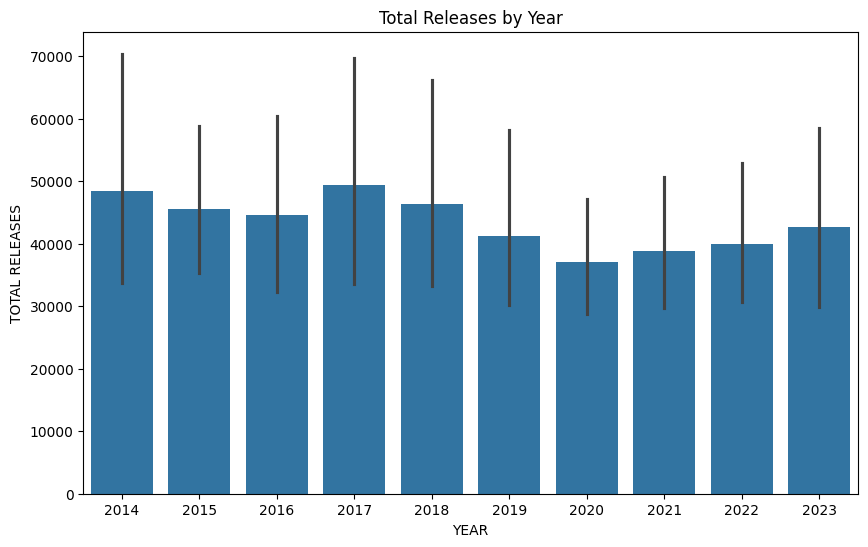

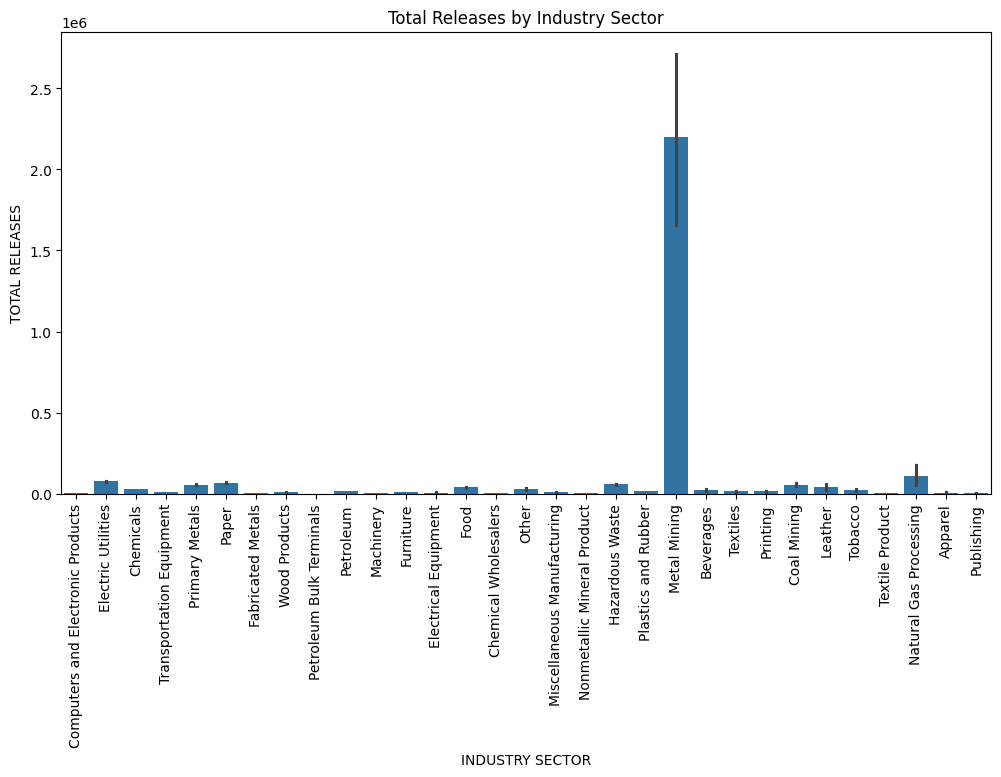

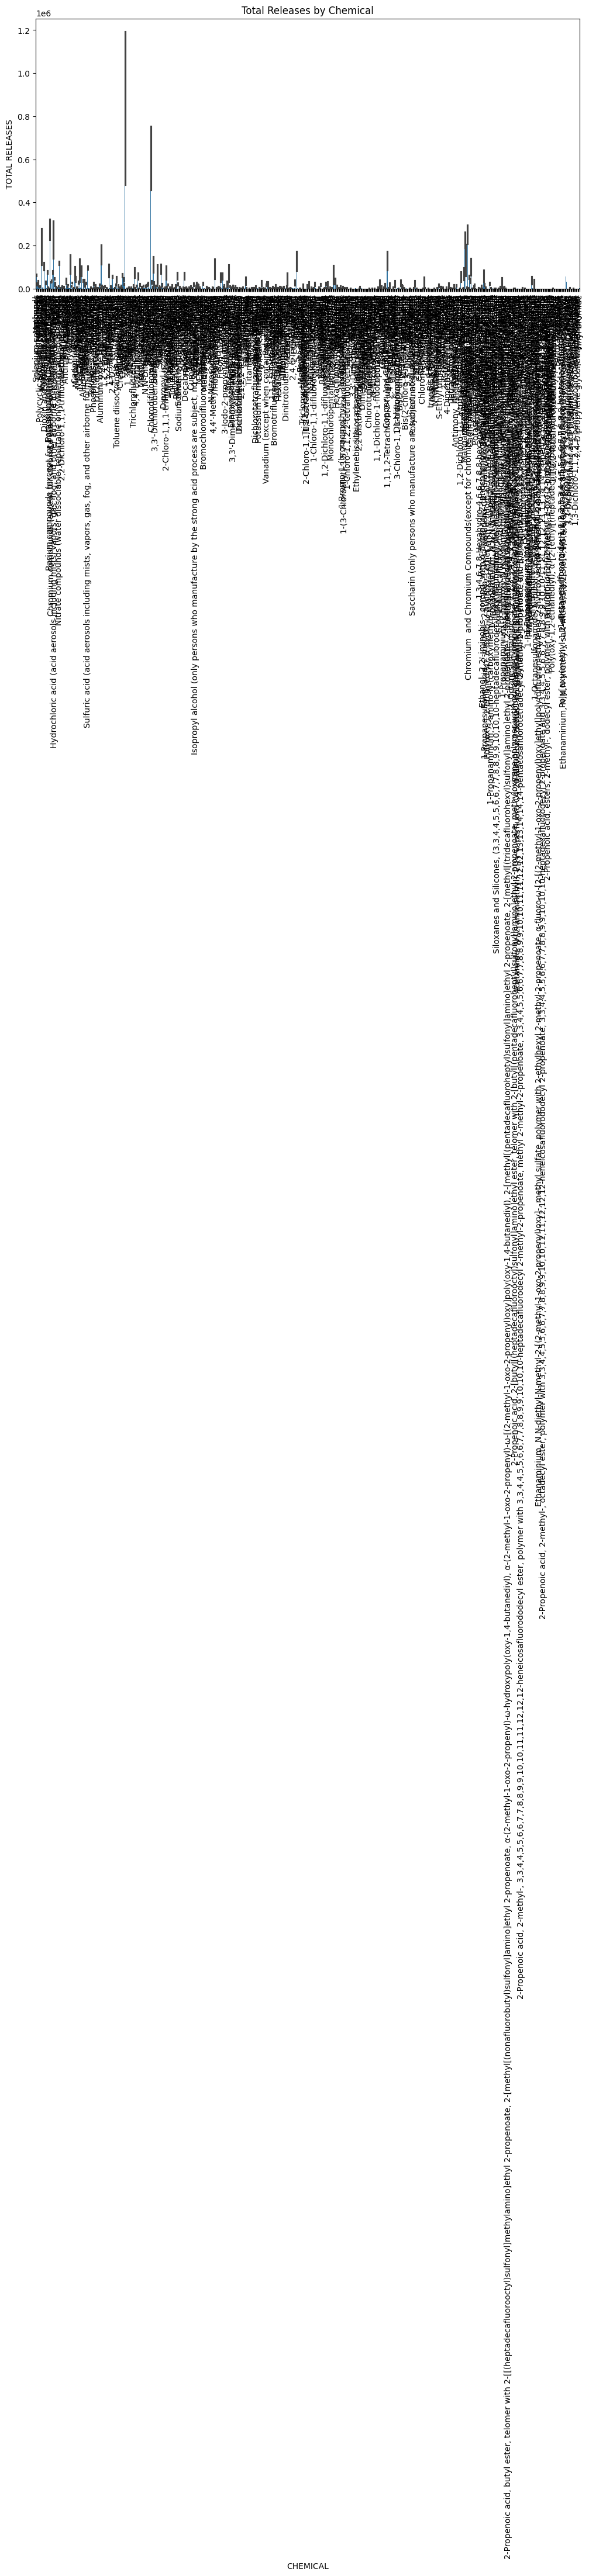

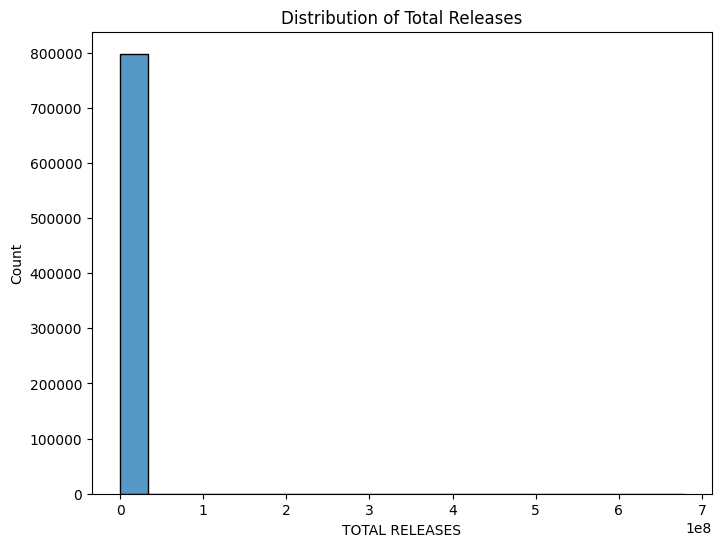

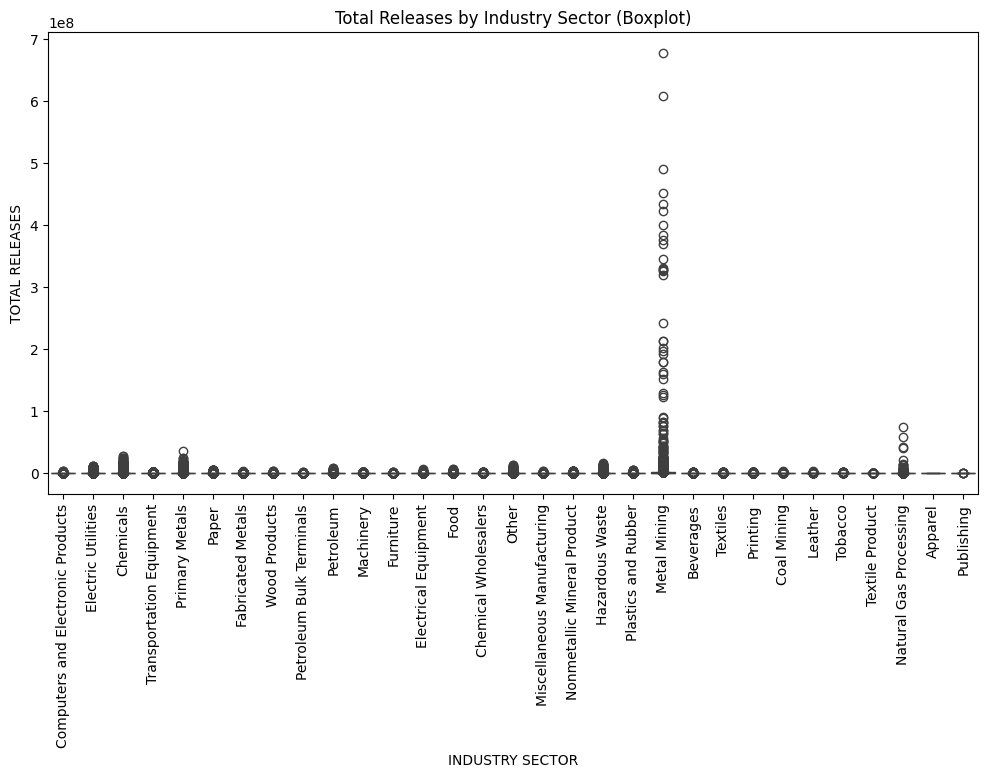

In [13]:
# Load the cleaned dataset
data = cleaned_data_u

# 1. Total Releases by Year
plt.figure(figsize=(10, 6))
sns.barplot(x='YEAR', y='TOTAL RELEASES', data=data)
plt.title('Total Releases by Year')
plt.show()

# 2. Total Releases by Industry (using 'INDUSTRY SECTOR')
plt.figure(figsize=(12, 6))
sns.barplot(x='INDUSTRY SECTOR', y='TOTAL RELEASES', data=data)
plt.title('Total Releases by Industry Sector')
plt.xticks(rotation=90)
plt.show()

# 3. Total Releases by Chemical
plt.figure(figsize=(12, 6))
sns.barplot(x='CHEMICAL', y='TOTAL RELEASES', data=data)
plt.title('Total Releases by Chemical')
plt.xticks(rotation=90)
plt.show()


# 4. Distribution of Total Releases
plt.figure(figsize=(8, 6))
sns.histplot(data['TOTAL RELEASES'], bins=20)
plt.title('Distribution of Total Releases')
plt.show()

# 5. Boxplot of Total Releases by Industry Sector
plt.figure(figsize=(12, 6))
sns.boxplot(x='INDUSTRY SECTOR', y='TOTAL RELEASES', data=data)
plt.title('Total Releases by Industry Sector (Boxplot)')
plt.xticks(rotation=90)
plt.show()


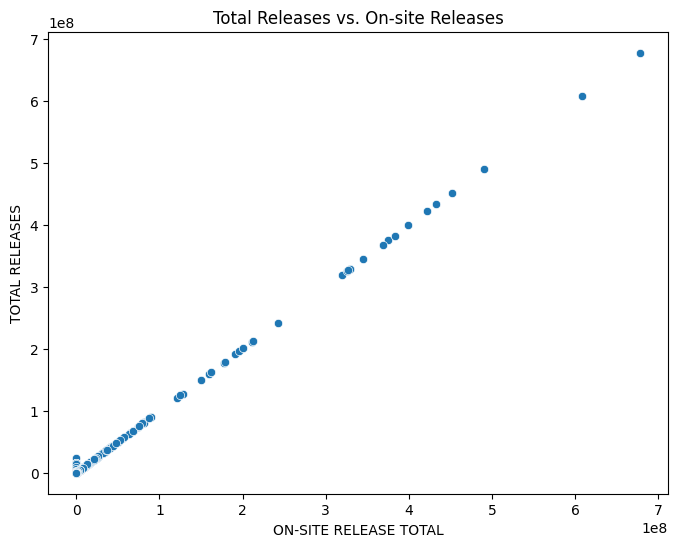

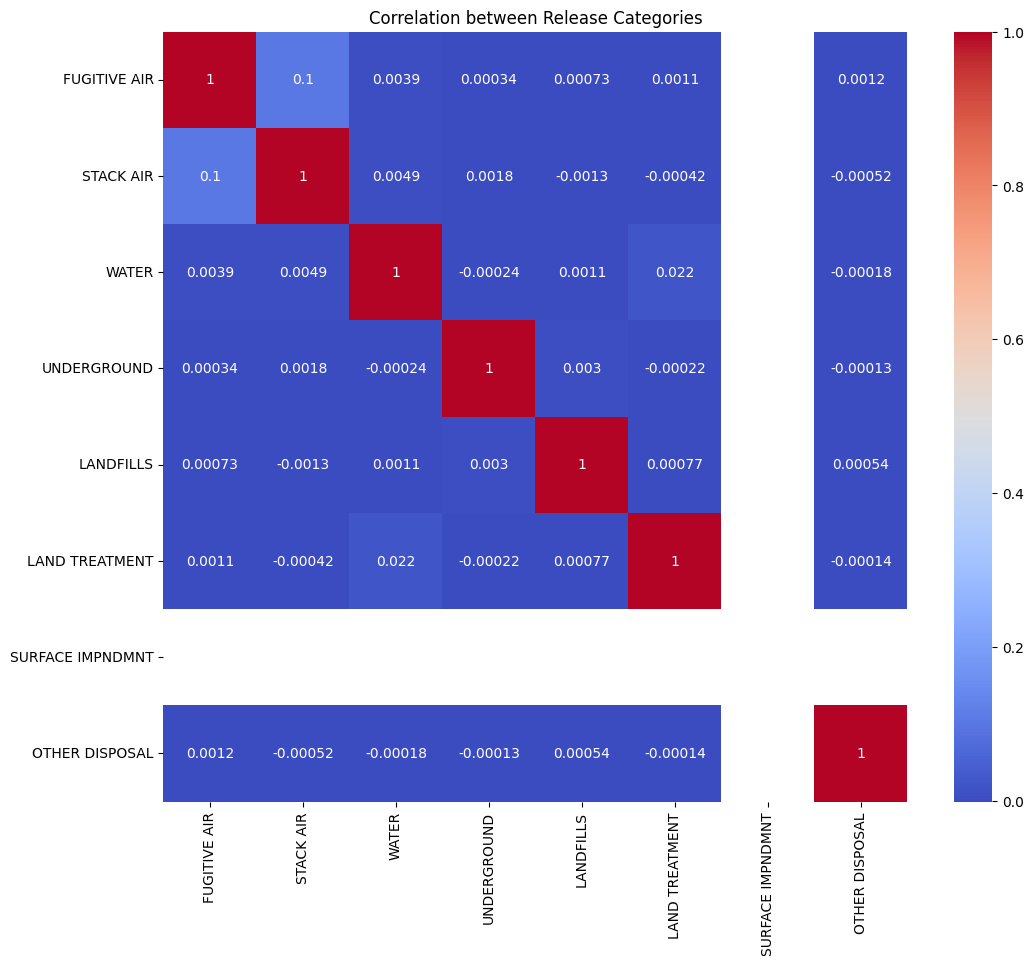

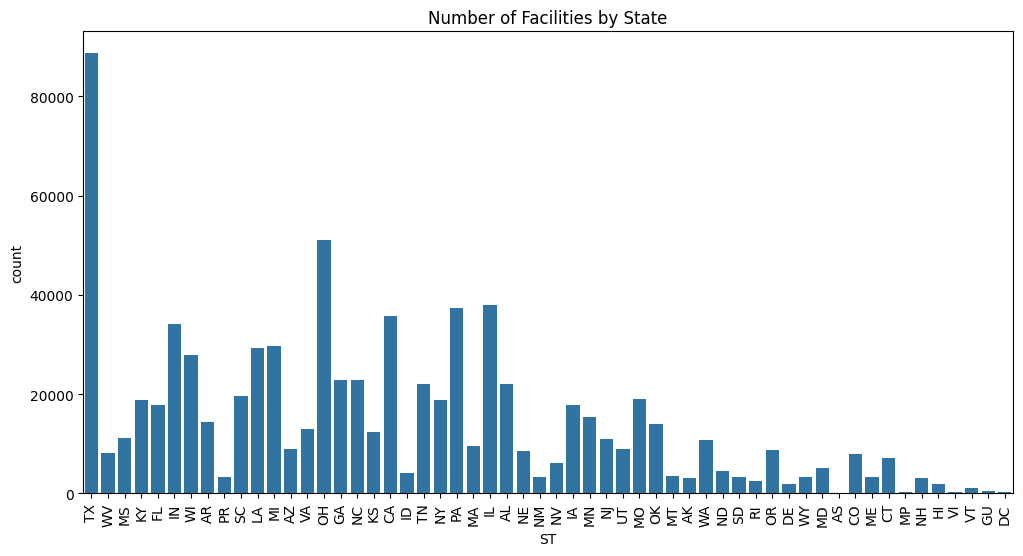

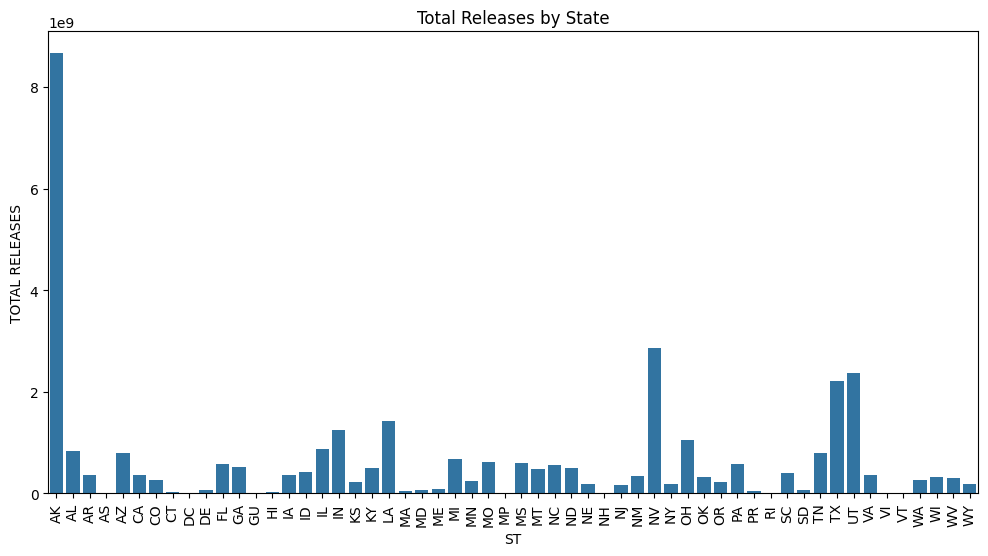

In [22]:

# 6. Scatter plot of Total Releases vs. On-site Releases
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ON-SITE RELEASE TOTAL', y='TOTAL RELEASES', data=data)
plt.title('Total Releases vs. On-site Releases')
plt.show()

# 7. Heatmap of Correlation between release categories
plt.figure(figsize=(12, 10))
correlation_matrix = data[[
    'FUGITIVE AIR', 'STACK AIR', 'WATER', 'UNDERGROUND', 'LANDFILLS',
    'LAND TREATMENT', 'SURFACE IMPNDMNT', 'OTHER DISPOSAL'
]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Release Categories')
plt.show()


# # 8. Pairplot of release categories
# sns.pairplot(data[[
#     'FUGITIVE AIR', 'STACK AIR', 'WATER', 'UNDERGROUND', 'LANDFILLS',
#     'LAND TREATMENT', 'SURFACE IMPNDMNT', 'OTHER DISPOSAL'
# ]])
# plt.show()


# 9. Barplot of releases by State
plt.figure(figsize=(12, 6))
sns.countplot(x='ST', data=data)
plt.title('Number of Facilities by State')
plt.xticks(rotation=90)
plt.show()

# 10. Releases by State (Total Releases)
state_releases = data.groupby('ST')['TOTAL RELEASES'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='ST', y='TOTAL RELEASES', data=state_releases)
plt.title('Total Releases by State')
plt.xticks(rotation=90)
plt.show()


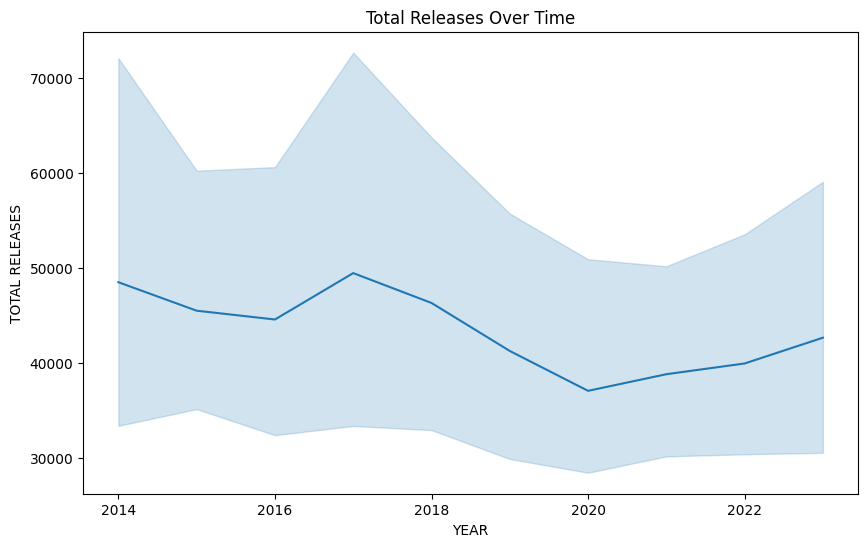

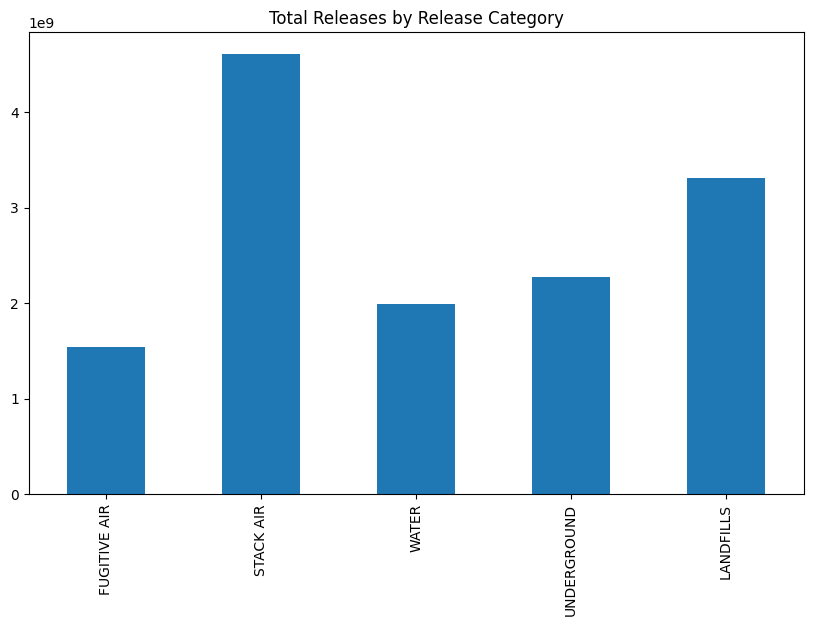

In [28]:


# # 11. Releases by Facility Type
# plt.figure(figsize=(12, 6))
# sns.countplot(x='FACILITY TYPE', data=data)
# plt.title('Number of Facilities by Type')
# plt.xticks(rotation=90)
# plt.show()

# # 12. Total Releases by Facility Type
# facility_releases = data.groupby('FACILITY TYPE')['TOTAL RELEASES'].sum().reset_index()
# plt.figure(figsize=(12, 6))
# sns.barplot(x='FACILITY TYPE', y='TOTAL RELEASES', data=facility_releases)
# plt.title('Total Releases by Facility Type')
# plt.xticks(rotation=90)
# plt.show()

# 13. Line plot of total releases over the years
plt.figure(figsize=(10, 6))
sns.lineplot(x='YEAR', y='TOTAL RELEASES', data=data)
plt.title('Total Releases Over Time')
plt.show()

# # 14. Releases by Chemical and Year
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='YEAR', y='TOTAL RELEASES', hue='CHEMICAL', data=data)
# plt.title('Total Releases by Chemical Over Time')
# plt.xticks(rotation=90)
# plt.show()

# 15. Stacked barplot of releases by different release categories
release_categories = ['FUGITIVE AIR', 'STACK AIR', 'WATER', 'UNDERGROUND', 'LANDFILLS']
release_data = data[release_categories].sum()
plt.figure(figsize=(10, 6))
release_data.plot(kind='bar', stacked=True)
plt.title('Total Releases by Release Category')
plt.show()


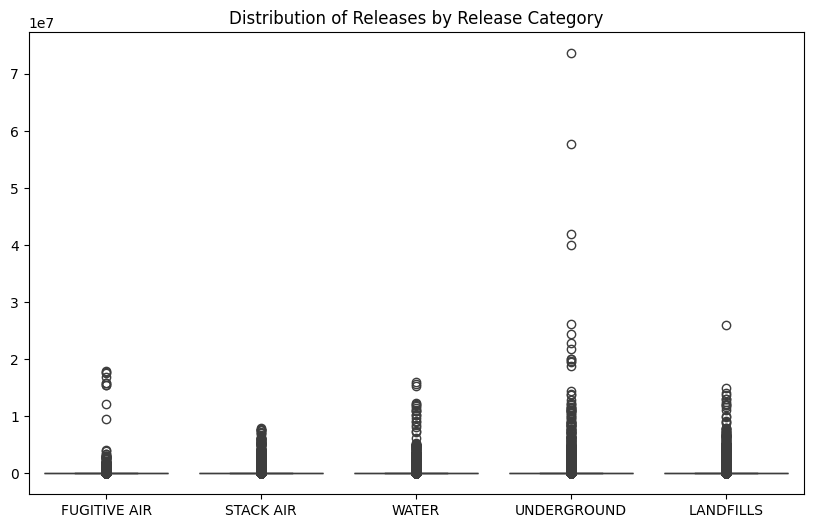

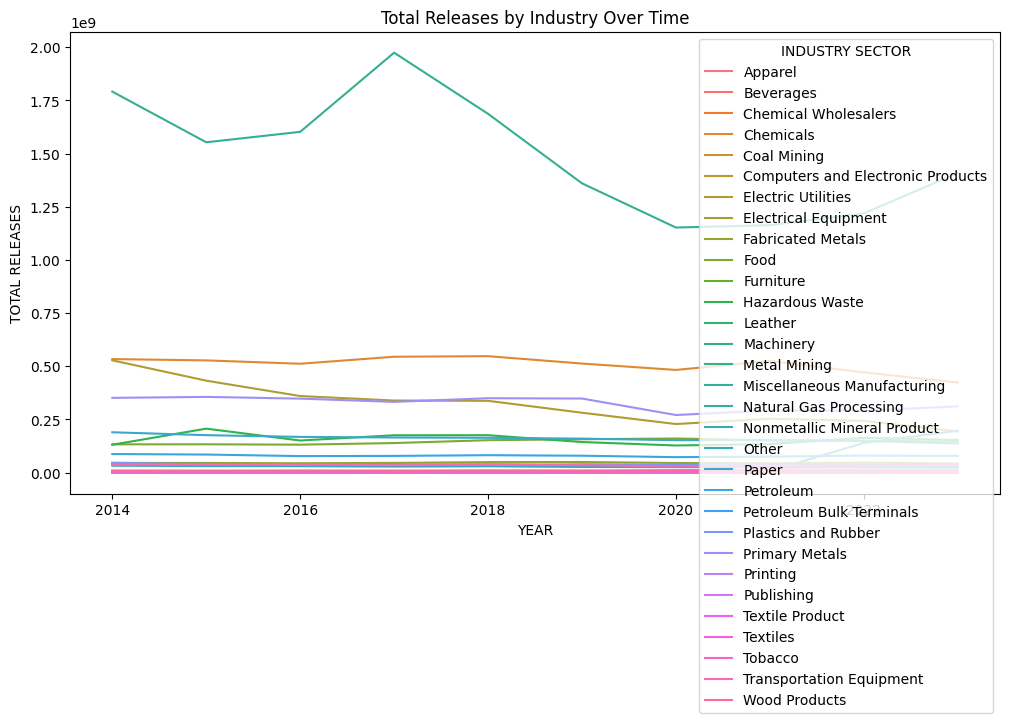

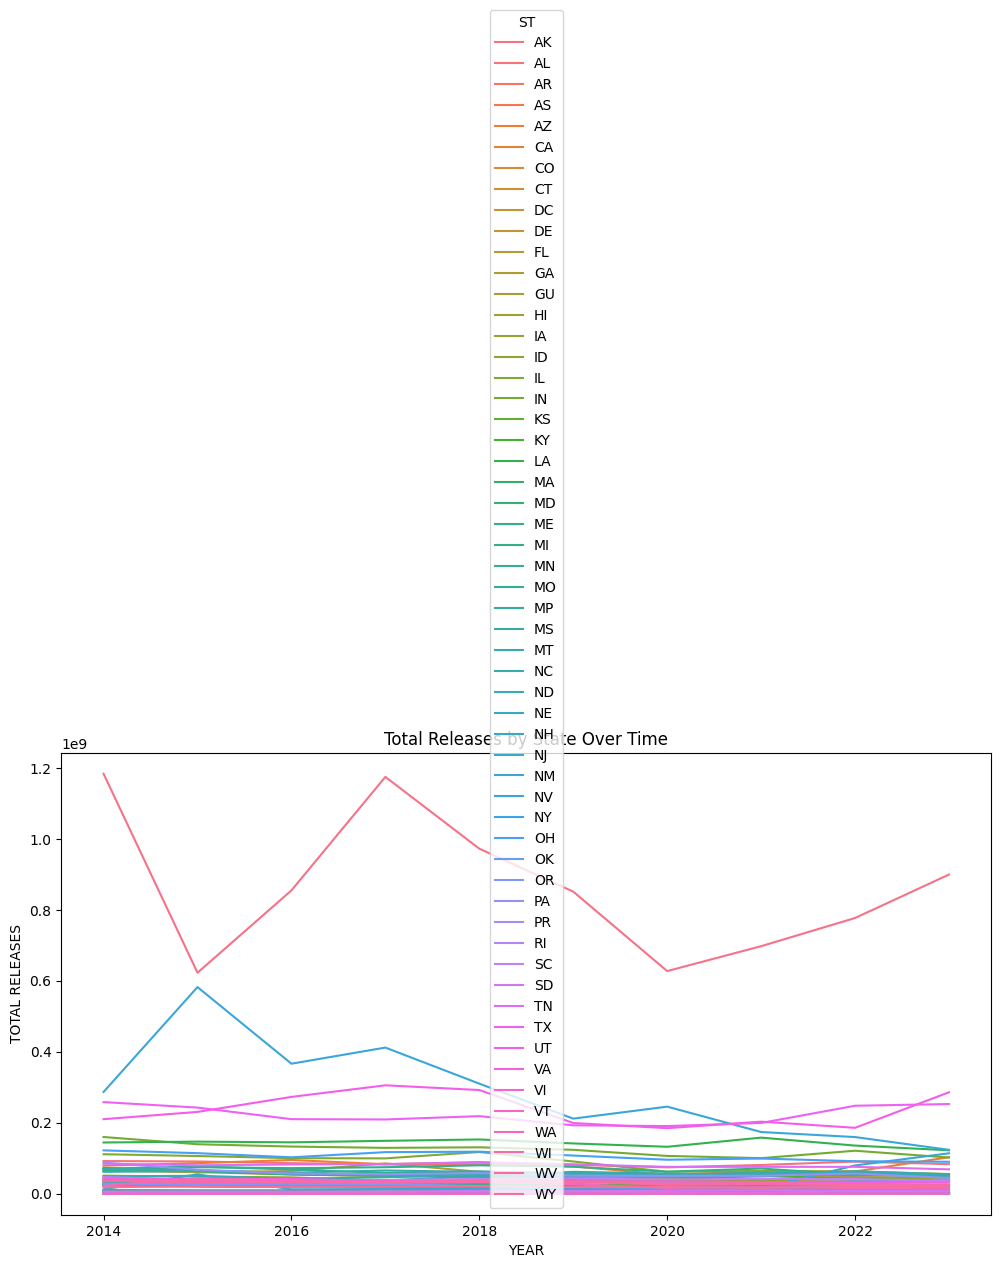

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


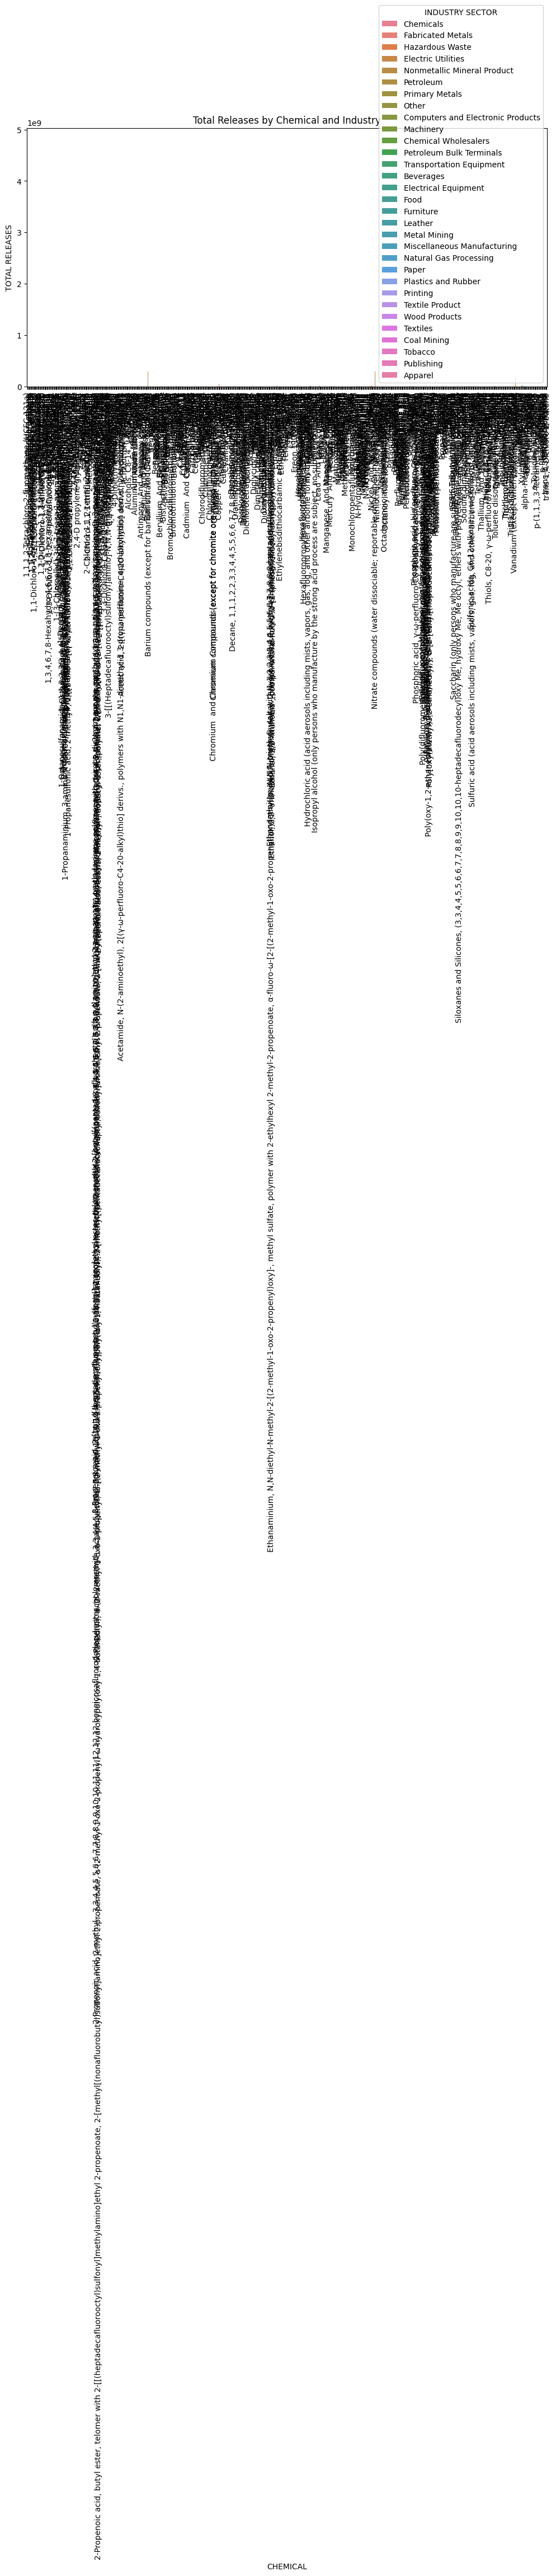

In [30]:

# 16. Boxplot of releases by different release categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[release_categories])
plt.title('Distribution of Releases by Release Category')
plt.show()

# # 17. Violin plot of releases by different release categories
# plt.figure(figsize=(10, 6))
# sns.violinplot(data=data[release_categories])
# plt.title('Distribution of Releases by Release Category')
# plt.show()

# 18.  Releases by Industry and Year
industry_year_releases = data.groupby(['INDUSTRY SECTOR', 'YEAR'])['TOTAL RELEASES'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='YEAR', y='TOTAL RELEASES', hue='INDUSTRY SECTOR', data=industry_year_releases)
plt.title('Total Releases by Industry Over Time')
plt.show()

# 19.  Releases by State and Year
state_year_releases = data.groupby(['ST', 'YEAR'])['TOTAL RELEASES'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='YEAR', y='TOTAL RELEASES', hue='ST', data=state_year_releases)
plt.title('Total Releases by State Over Time')
plt.show()


# 20.  Releases by Chemical and Industry
chemical_industry_releases = data.groupby(['CHEMICAL', 'INDUSTRY SECTOR'])['TOTAL RELEASES'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='CHEMICAL', y='TOTAL RELEASES', hue='INDUSTRY SECTOR', data=chemical_industry_releases)
plt.title('Total Releases by Chemical and Industry')
plt.xticks(rotation=90)
plt.show()

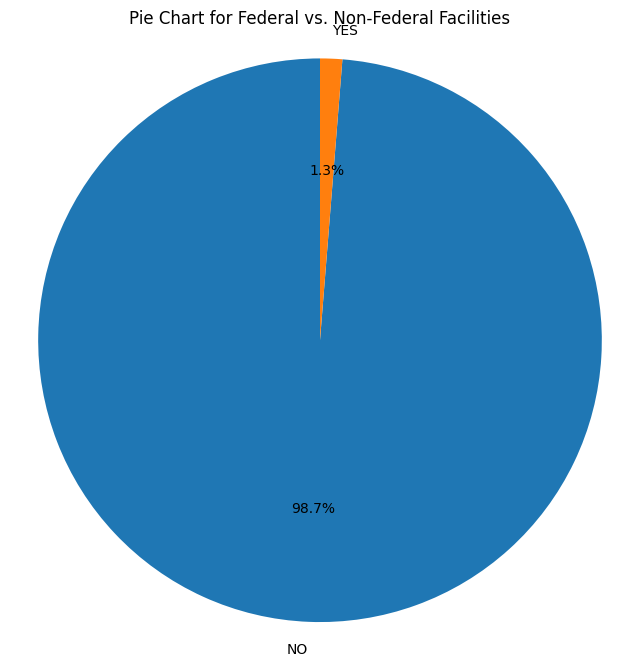

In [35]:
federal_vs_non_federal = data['FEDERAL FACILITY'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(federal_vs_non_federal, labels=federal_vs_non_federal.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Federal vs. Non-Federal Facilities')
plt.axis('equal')
plt.show()

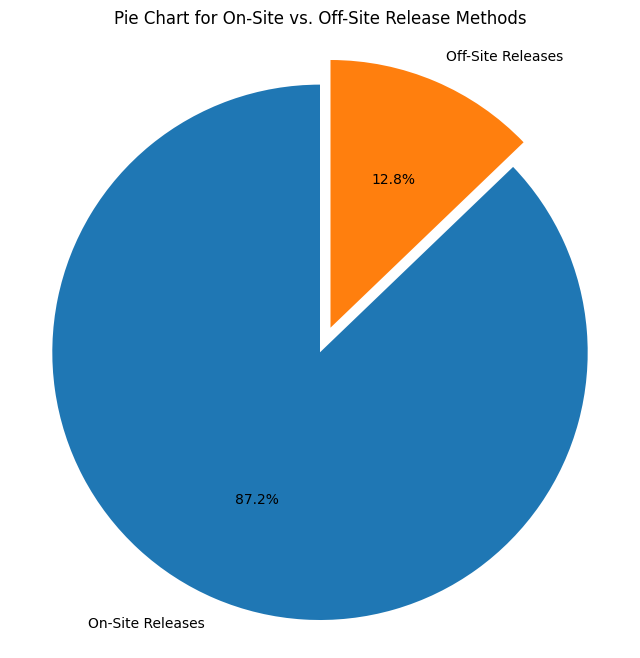

In [36]:
onsite_releases = data['ON-SITE RELEASE TOTAL'].sum()
offsite_releases = data['OFF-SITE RELEASE TOTAL'].sum()

# Create the pie chart
labels = ['On-Site Releases', 'Off-Site Releases']
sizes = [onsite_releases, offsite_releases]
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for On-Site vs. Off-Site Release Methods')
plt.axis('equal')
plt.show()

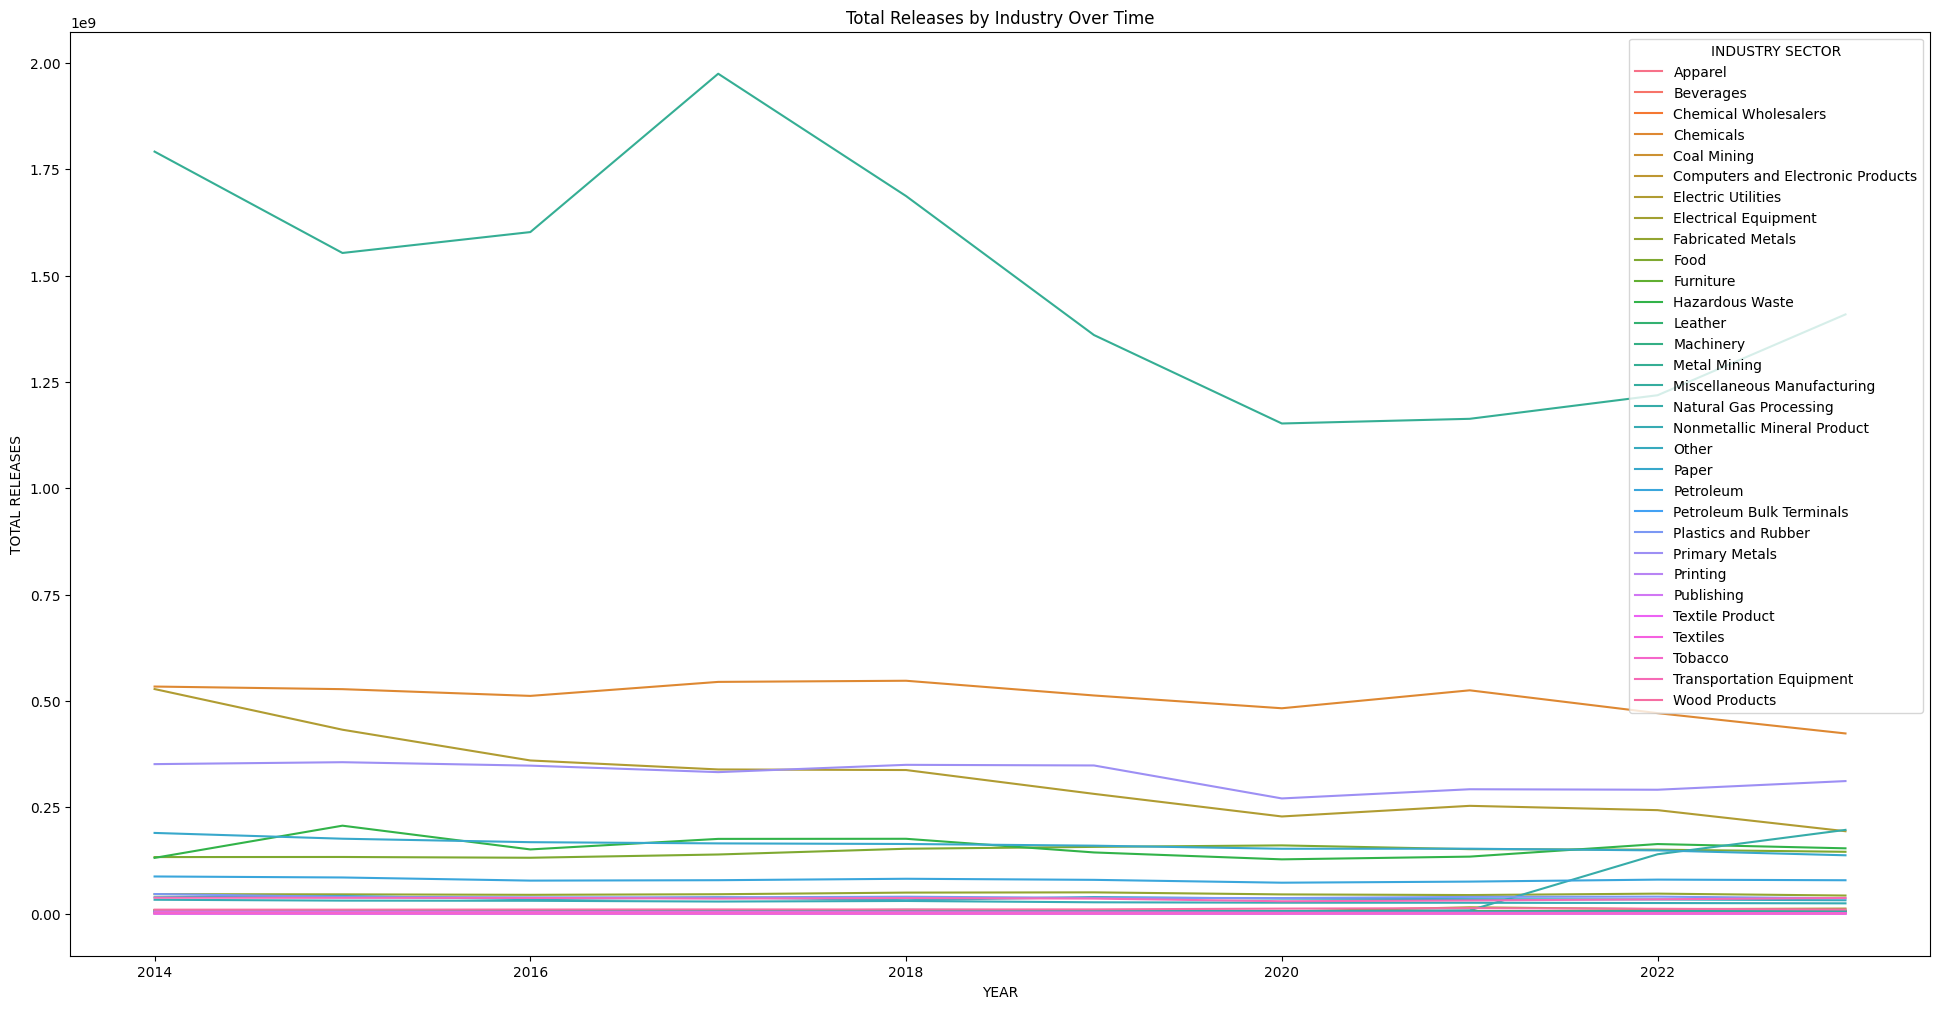

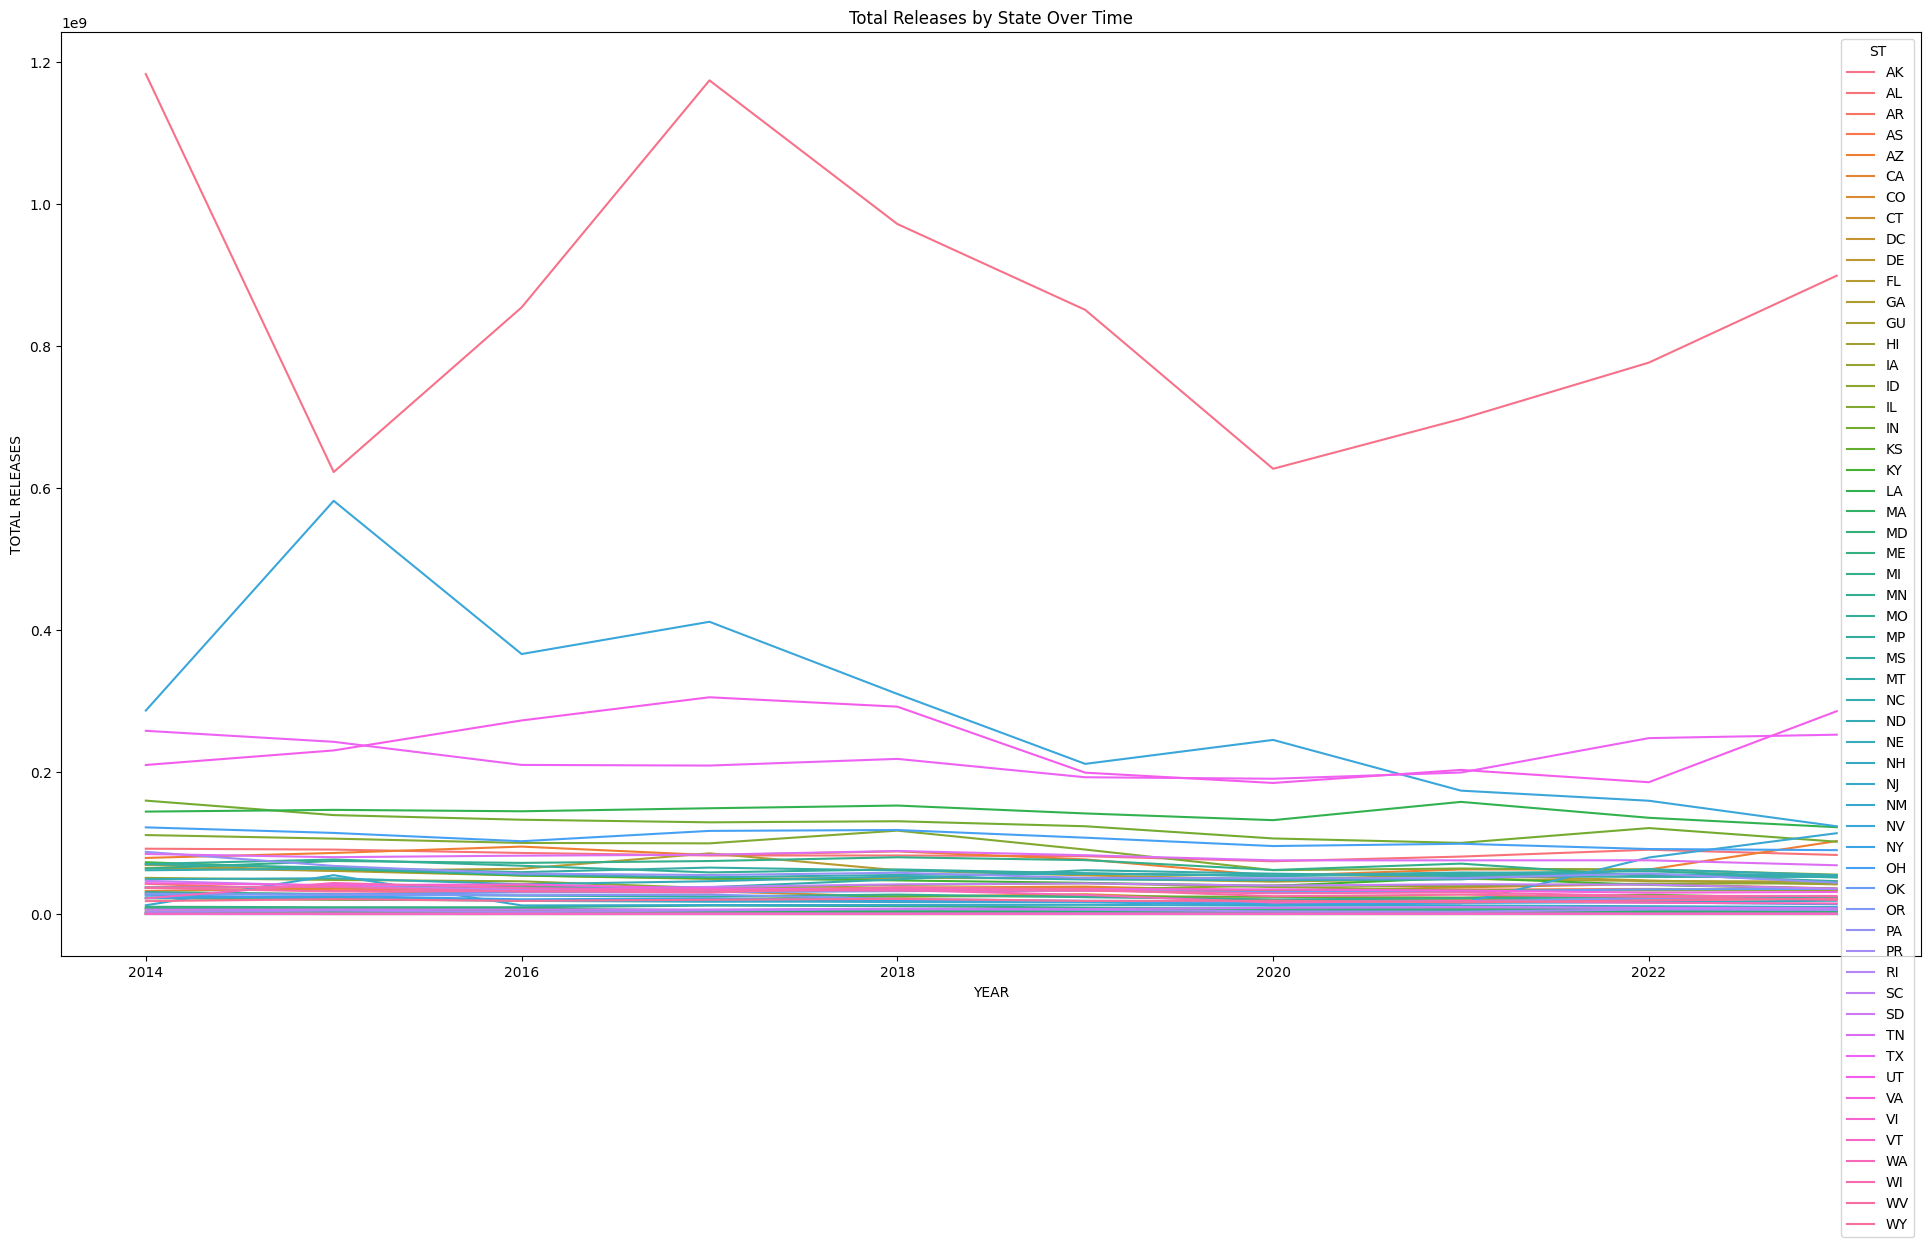

In [43]:
# 18.  Releases by Industry and Year
industry_year_releases = data.groupby(['INDUSTRY SECTOR', 'YEAR'])['TOTAL RELEASES'].sum().reset_index()
plt.figure(figsize=(24, 12))
sns.lineplot(x='YEAR', y='TOTAL RELEASES', hue='INDUSTRY SECTOR', data=industry_year_releases)
plt.title('Total Releases by Industry Over Time')
plt.show()

# 19.  Releases by State and Year
state_year_releases = data.groupby(['ST', 'YEAR'])['TOTAL RELEASES'].sum().reset_index()
plt.figure(figsize=(24, 12))
sns.lineplot(x='YEAR', y='TOTAL RELEASES', hue='ST', data=state_year_releases)
plt.title('Total Releases by State Over Time')
plt.show()


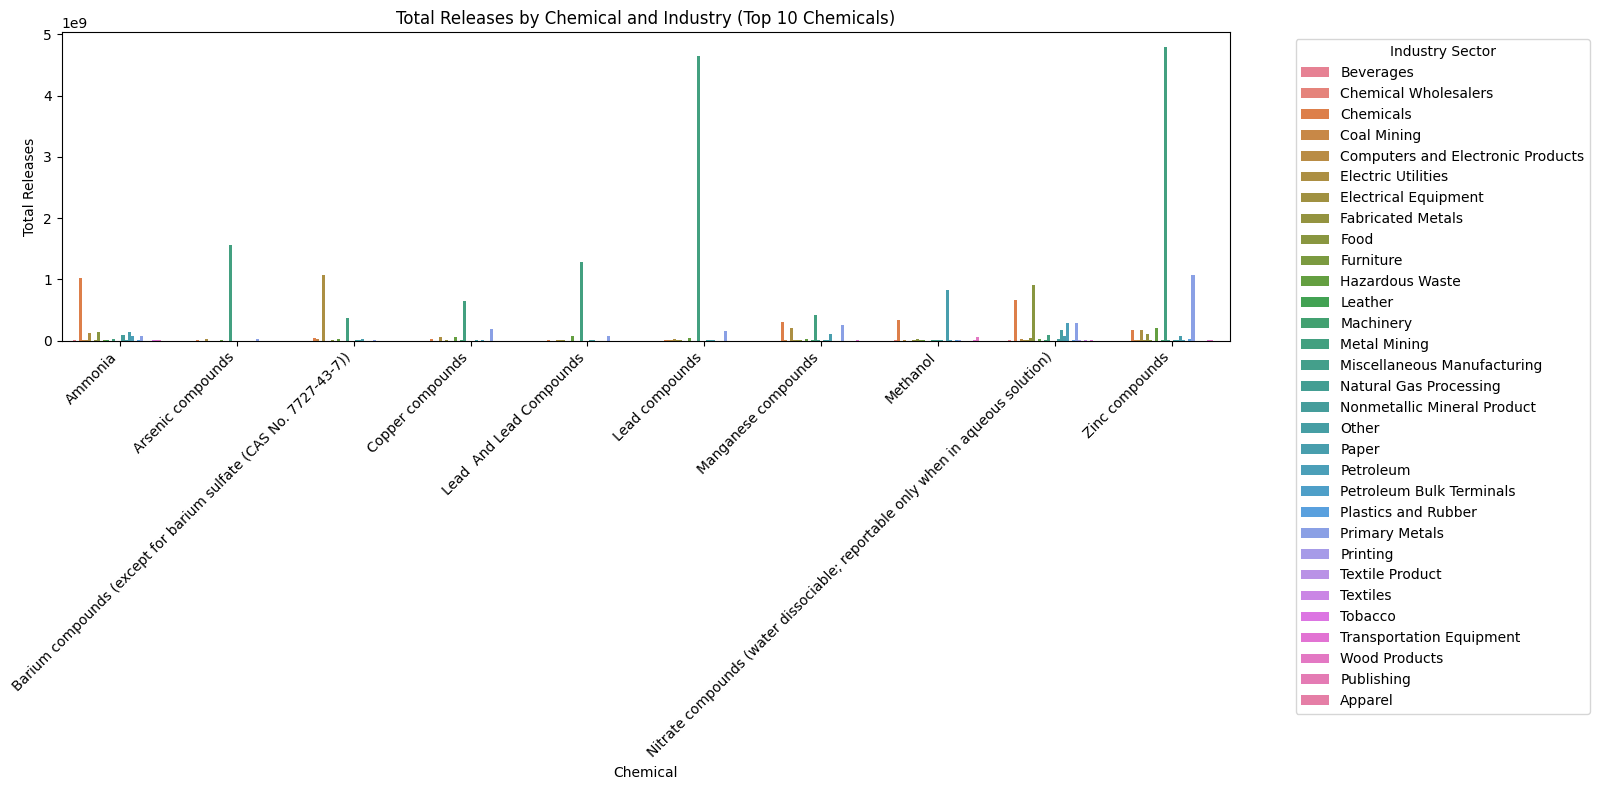

In [17]:

chemical_industry_releases = data.groupby(['CHEMICAL', 'INDUSTRY SECTOR'])['TOTAL RELEASES'].sum().reset_index()

# Get the top 10 chemicals based on total releases
top_10_chemicals = chemical_industry_releases.groupby('CHEMICAL')['TOTAL RELEASES'].sum().sort_values(ascending=False).head(10).index.tolist()

chemical_industry_releases_top_10 = chemical_industry_releases[chemical_industry_releases['CHEMICAL'].isin(top_10_chemicals)]

plt.figure(figsize=(16, 8))
sns.barplot(x='CHEMICAL', y='TOTAL RELEASES', hue='INDUSTRY SECTOR', data=chemical_industry_releases_top_10)
plt.title('Total Releases by Chemical and Industry (Top 10 Chemicals)')
plt.xlabel('Chemical')
plt.ylabel('Total Releases')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Industry Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

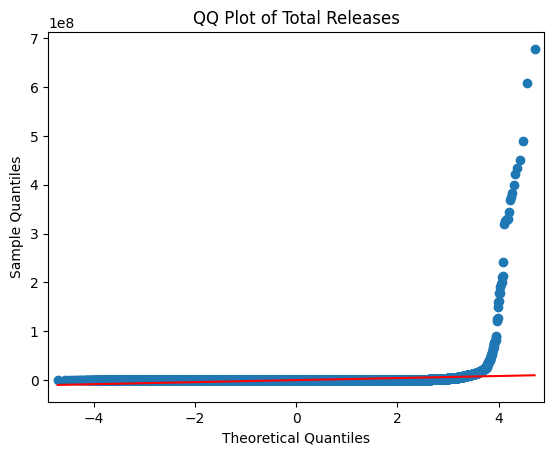

In [16]:
variable_to_analyze = data['TOTAL RELEASES']

# Generate the QQ plot
sm.qqplot(variable_to_analyze, line='s')
plt.title('QQ Plot of Total Releases')
plt.show()